In [1]:
import json 
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
from scipy.stats import pearsonr

In [2]:
# triples with original refs
# 30 dropout runs    
# each triple has mean and std score

#zeus

# f = open ('/media/hdd1/glushkovato/comet/segments.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/segments-fulltrain-dropout-01.json', "r") 
# f = open('/media/hdd1/glushkovato/comet/segments-3hqref.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-3hqref-fulltrain-dropout-01.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-lw-dropout-01.json', 'r')

# f = open('/media/hdd1/glushkovato/comet/segments-fulltrain-90dpruns.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-fulltrain-60dpruns.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-hqp-hqr-fulltrain.json', 'r')

# f = open('/media/hdd1/glushkovato/comet/segments-ar-arp-wmtp-fulltrain.json', 'r')
f = open('/media/hdd1/glushkovato/comet/segments-orig-ar-arp-wmtp-fulltrain.json', 'r')


# f = open('/media/hdd1/glushkovato/comet/segments-hqp-hqr-fulltrain-upd.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-ar—arp-wmtp-fulltrain-upd.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/system-6674.json', 'r')


# 'system-6823.json'


# segments-ar-arp-wmtp-fulltrain-upd.json
# segments-orig-ar-arp-wmtp-fulltrain.json



# - - - - - - - - - - - - - - - - 
# f = open ('/media/hdd1/glushkovato/comet/test-out.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/segments-arp-ref-norm.json', "r") 

data = json.loads(f.read()) 
f.close() 

In [3]:
from os import listdir
from os.path import isfile, join

mt_path = '/media/hdd1/glushkovato/comet/'
files = [f for f in listdir(mt_path) if isfile(join(mt_path, f))]
sys_files = [f for f in files if f.split('_')[0] == 'system']

In [4]:
len(sys_files)

22

In [5]:
da_scores = pd.read_csv('/media/hdd1/glushkovato/comet/COMET_uncertainty/data/nd_en_de_scores_merged.csv')
da_scores.system = da_scores.system.apply(lambda x: x.split('.')[0])

In [6]:
system_scores = []
system_stds = []
avg_das = []

In [11]:
system_scores

[0.255457,
 0.127766,
 -0.28893,
 0.047383,
 0.251051,
 0.159427,
 0.013315,
 0.043957,
 0.180965,
 -0.050526,
 0.105866,
 0.121775,
 0.071535,
 0.171964,
 0.029811,
 0.120675,
 0.138071,
 0.095485,
 0.010618,
 -1.458049,
 0.246514,
 0.169071]

In [12]:
system_stds

[0.001845,
 0.00234,
 0.002271,
 0.001863,
 0.002112,
 0.00205,
 0.00208,
 0.002671,
 0.002614,
 0.002683,
 0.002484,
 0.001696,
 0.002392,
 0.002346,
 0.002043,
 0.002168,
 0.002306,
 0.002943,
 0.00205,
 0.002374,
 0.002245,
 0.002299]

In [13]:
avg_das

[0.3465381976497918,
 0.08140655411858705,
 -0.40008188651701454,
 0.03824320739831662,
 0.2957295521274711,
 0.1885804900706152,
 -0.13162656360236166,
 -0.07438097007828845,
 0.21398600860287684,
 -0.11953477007817244,
 0.1186880549613414,
 0.09375289547066215,
 0.008199408910924948,
 0.21299480398987627,
 0.0014992544066896635,
 0.09327448855825063,
 0.12958253273773365,
 0.0773111487421611,
 -0.12914966913042827,
 -1.7688750326823277,
 0.3109616791175547,
 0.20821975784905983]

In [14]:
# system level
probs = []
# list_das = [np.mean(z_scores)]*30
for i, q in enumerate(avg_das):
    prob = norm.pdf(q, system_scores[i], system_stds[i])
    probs.append(prob)
avg_logl_system = round(np.sum(np.log(probs+eps))/len(probs), 6) #! the value we want to compare (want: as big as possible) 
avg_logl_system

-30.885279

In [15]:
# system level
score_diff = [abs(zs - cs) for zs, cs in zip(avg_das, system_scores)]
systems_pearson_corr = pearsonr(score_diff, system_stds)
systems_pearson_corr2 = pearsonr(avg_das, system_scores)

In [16]:
systems_pearson_corr

(0.031525584580355724, 0.88923614727722)

In [17]:
systems_pearson_corr2

(0.9932863778125682, 3.2652973449731265e-20)

In [10]:
for s in sys_files:
    f = open('/media/hdd1/glushkovato/comet/' + s, 'r')
    data = json.loads(f.read()) 
    f.close() 

    system_name = '_'.join(s.split('.')[0].split('_')[1:])
    lines = [[i['src'], i['mt'], i['ref'], i['dp_runs_scores']] for i in data if 'dp_runs_scores' in i.keys()]
    df_ = pd.DataFrame(data=np.array(lines), columns=['src','mt', 'ref', 'dp_runs_scores'])
    da_scores_ = da_scores[da_scores.system == system_name]
    df = df_.merge(da_scores_, how='inner', on=['src', 'mt'])

    df['predicted_score_mean'] = df['dp_runs_scores'].apply(lambda x: np.mean(x)) # segment-level
    df['predicted_score_std'] = df['dp_runs_scores'].apply(lambda x: np.std(x)) # segment-level
    df['q-mu'] = np.abs(df['z_score'] - df['predicted_score_mean'])
    df.drop(['ref_x', 'ref_y', 'lp', 'raw_score', 'annotators', 'extra_ref'], axis=1, inplace=True)
    
    system_means = np.mean(df.dp_runs_scores.tolist(), axis=0) # 30 vals
#     system_stds = np.std(df.dp_runs_scores.tolist(), axis=0)

    system_score = np.mean(system_means)  # mean([30 mean values, where each is a mean of 1 dp run])
    system_std = np.std(system_means)  # how different system score is between 30 dp runs

    z_scores = df['z_score'].tolist()
    mean_vals = df['predicted_score_mean'].tolist()
    std_vals = df['predicted_score_std'].tolist()

    eps = np.finfo(float).eps # to avoid -inf when computing np.log(0)
    
    # segment level
    probs = []
    for i, q in enumerate(z_scores):
        prob = norm.pdf(q, mean_vals[i], std_vals[i])
        probs.append(prob)
    avg_logl_segment = round(np.sum(np.log(probs+eps))/len(probs), 6) #! the value we want to compare (want: as big as possible) 

    # segment level
    score_diff=[abs(zs - cs) for zs, cs in zip(z_scores, mean_vals)]
    pearson_corr = pearsonr(score_diff, std_vals)
    pearson_corr2 = pearsonr(z_scores, mean_vals)

    print('!!! ' + system_name + ' !!!')
    print('segment min std: ', round(min(std_vals), 6))
    print('segment max std: ', round(max(std_vals), 6))
    
    print('mean DA: ', round(np.mean(z_scores), 6))
    print('system score: ', round(system_score, 6))
    print('system std: ', round(system_std, 6))

    system_scores.append(round(system_score, 6))
    system_stds.append(round(system_std, 6))
    avg_das.append(np.mean(z_scores))

    print('avg_logl_segment: ', avg_logl_segment)
    print('pearson_abs: ', round(pearson_corr[0], 6))
    print('pearson_comet_da: ', round(pearson_corr2[0], 6))
    print('system_score*(1 - system_std): ', round(system_score*(1 - system_std), 6))
    print()


/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


!!! Facebook_FAIR !!!
segment min std:  0.018571
segment max std:  0.354488
mean DA:  0.346538
system score:  0.255457
system std:  0.001845
avg_logl_segment:  -13.093915
pearson_abs:  0.274578
pearson_comet_da:  0.396684
system_score*(1 - system_std):  0.254985

!!! JHU !!!
segment min std:  0.016392
segment max std:  0.20228
mean DA:  0.081407
system score:  0.127766
system std:  0.00234
avg_logl_segment:  -13.144213
pearson_abs:  0.28279
pearson_comet_da:  0.538851
system_score*(1 - system_std):  0.127467

!!! online-X !!!
segment min std:  0.023855
segment max std:  0.276679
mean DA:  -0.400082
system score:  -0.28893
system std:  0.002271
avg_logl_segment:  -17.063935
pearson_abs:  0.116029
pearson_comet_da:  0.62335
system_score*(1 - system_std):  -0.288274

!!! online-Y !!!
segment min std:  0.020373
segment max std:  0.257451
mean DA:  0.038243
system score:  0.047383
system std:  0.001863
avg_logl_segment:  -14.431217
pearson_abs:  0.215777
pearson_comet_da:  0.555422
system_s

In [16]:
len(df_.dp_runs_scores.tolist()) # 30

1997

In [20]:
np.std(df_.dp_runs_scores.tolist(), axis=0)

array([0.35533641, 0.35499516, 0.35514336, 0.35296302, 0.35482293,
       0.35102637, 0.35767004, 0.35448418, 0.35767053, 0.35765875,
       0.3552925 , 0.35492914, 0.35162798, 0.35701737, 0.35463925,
       0.35315688, 0.35293709, 0.35479219, 0.35261795, 0.35171154,
       0.35427587, 0.35711028, 0.35652794, 0.35515305, 0.34937838,
       0.35615662, 0.35861403, 0.35558703, 0.35250616, 0.35397557])

In [ ]:
for sys_f in sys_files:
    f = open('/media/hdd1/glushkovato/comet/segments-orig-ar-arp-wmtp-fulltrain.json', 'r')
    

In [4]:
data[0]

{'src': "Welsh AMs worried about 'looking like muppets'",
 'mt': 'Waliser AMs besorgt darüber, „wie Muppets auszusehen“',
 'ref': 'Walisische Ageordnete sorgen sich "wie Dödel auszusehen"',
 'predicted_score_mean': -0.6173082540432612,
 'predicted_score_std': 0.3898234350980552}

In [5]:
lines = []
for i in data:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])

In [6]:
df_ = pd.DataFrame(data=np.array(lines), 
                   columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df.iloc[:6]

df_ = df_.iloc[::4, :]
df_.iloc[:3]

,src,mt,ref,predicted_score_mean,predicted_score_std
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Ageordnete sorgen sich ""wie Dödel a...",-0.6173082540432612,0.3898234350980552
4,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Es herrscht Bestürzung unter einigen Mitgliede...,0.23350391974672674,0.1622791799177011
8,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Der Grund dafür waren Pläne, den Namen der Nat...",0.1446404880223175,0.23165418689334058


In [7]:
df_.shape

(1997, 5)

In [8]:
# da_scores = pd.read_csv('/media/hdd1/glushkovato/comet/COMET_uncertainty/data/da_scores_combined_ref.csv')
# da_scores.iloc[:3]

In [21]:
da_scores = pd.read_csv('/media/hdd1/glushkovato/comet/COMET_uncertainty/data/nd_en_de_scores_merged.csv')
# da_scores.iloc[:3]
da_scores.system.unique()

array(['Microsoft-WMT19-document-level.6808', 'UdS-DFKI.6871', 'JHU.6819',
       'MLLP-UPV.6651', 'Facebook_FAIR.6862', 'en_de_task.6790',
       'UCAM.6731', 'NEU.6763', 'Microsoft-WMT19-sentence_document.6974',
       'online-G.0', 'online-X.0', 'eTranslation.6823', 'online-B.0',
       'dfki-nmt.6479', 'Microsoft-WMT19-sentence-level.6785',
       'Helsinki-NLP.6820', 'online-Y.0', 'lmu-ctx-tf-single-en-de.6981',
       'MSRA.MADL.6926', 'PROMT_NMT_EN-DE.6674', 'online-A.0',
       'TartuNLP-c.6508'], dtype=object)

In [10]:
da_scores_fb = da_scores[da_scores.system == 'Facebook_FAIR.6862'] # Facebook_FAIR.6862 PROMT_NMT_EN-DE.6674
da_scores_fb.shape

(1744, 9)

In [11]:
df = df_.merge(da_scores_fb, how='inner', on=['src', 'mt'])
df.iloc[:2]

,src,mt,ref_x,predicted_score_mean,predicted_score_std,lp,system,ref_y,extra_ref,z_score,raw_score,annotators
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Ageordnete sorgen sich ""wie Dödel a...",-0.6173082540432612,0.3898234350980552,en-de,Facebook_FAIR.6862,"Walisische Ageordnete sorgen sich ""wie Dödel a...","Walisische Abgeordnete befürchten als ,Idioten...",0.696150,96.5,2
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Es herrscht Bestürzung unter einigen Mitgliede...,0.23350391974672674,0.1622791799177011,en-de,Facebook_FAIR.6862,Es herrscht Bestürzung unter einigen Mitgliede...,Bei einigen AMs herrscht Fassungslosigkeit übe...,-0.652806,68.0,1


In [12]:
# df['z_score'] = da_scores['z_score'].tolist()
# df['z_score_norm'] = da_scores['z_score_norm'].tolist()

cols = ['predicted_score_mean', 'predicted_score_std', 'z_score']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df.iloc[:2]

,src,mt,ref_x,predicted_score_mean,predicted_score_std,lp,system,ref_y,extra_ref,z_score,raw_score,annotators
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Ageordnete sorgen sich ""wie Dödel a...",-0.617308,0.389823,en-de,Facebook_FAIR.6862,"Walisische Ageordnete sorgen sich ""wie Dödel a...","Walisische Abgeordnete befürchten als ,Idioten...",0.696150,96.5,2
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Es herrscht Bestürzung unter einigen Mitgliede...,0.233504,0.162279,en-de,Facebook_FAIR.6862,Es herrscht Bestürzung unter einigen Mitgliede...,Bei einigen AMs herrscht Fassungslosigkeit übe...,-0.652806,68.0,1


In [13]:
df.shape

(1744, 12)

In [14]:
# df = df.dropna()
# df.shape

In [15]:
df['q-mu'] = np.abs(df['z_score'] - df['predicted_score_mean'])

In [16]:
df.drop(['ref_x', 'ref_y', 'lp', 'raw_score', 'annotators', 'extra_ref'], axis=1, inplace=True)

In [17]:
z_scores = df['z_score'].tolist()
mean_vals = df['predicted_score_mean'].tolist()
std_vals = df['predicted_score_std'].tolist()

In [18]:
print('min std: ', round(min(std_vals), 6))
print('max std: ', round(max(std_vals), 6))

min std:  0.04281
max std:  1.128201


In [19]:
print('mean std: ', round(np.mean(std_vals), 6))
print('mean comet: ', round(np.mean(mean_vals), 6))
print('mean da: ', round(np.mean(z_scores), 6))

mean std:  0.206885
mean comet:  0.304109
mean da:  0.346538


## data plots

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Math, Latex
from IPython.core.display import Image
import seaborn as sns
sns.set(color_codes=True)

sns.set(rc={'figure.figsize':(10,5)}) # seaborn plot sizes

### test example

In [13]:
from scipy.stats import norm

# data_normal = norm.rvs(size=10000,loc=0,scale=1) # random numbers from N(0,1)

In [22]:
# ax = sns.distplot(sorted(data_normal),
#                   bins=100,
#                   kde=True,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1})
# ax.set(xlabel='Normal Distribution', ylabel='Frequency')

### our data

mean values for each triple

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'mean_vals distribution'), Text(0, 0.5, 'Frequency')]

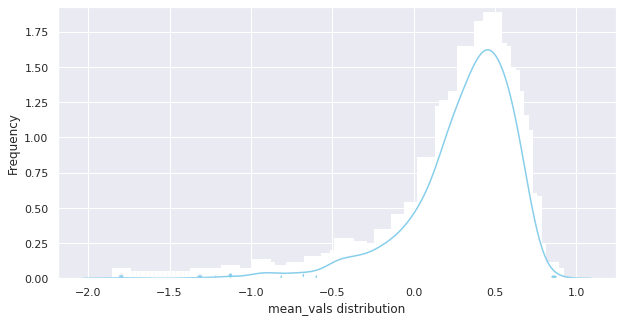

In [23]:
ax = sns.distplot(mean_vals,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='mean_vals distribution', ylabel='Frequency')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'z_scores distribution'), Text(0, 0.5, 'Frequency')]

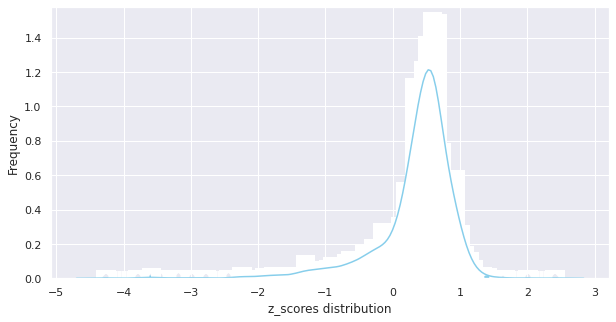

In [24]:
ax = sns.distplot(z_scores,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='z_scores distribution', ylabel='Frequency')

In [25]:
tmp_df = df[['predicted_score_mean', 'predicted_score_std', 'z_score', 'q-mu']]
tmp_df.columns = ['comet_mean', 'comet_std', 'da_score', '|da_score-comet_mean|']
tmp_df.head()

,comet_mean,comet_std,da_score,|da_score-comet_mean|
0,-0.617308,0.389823,0.696150,1.313458
1,0.233504,0.162279,-0.652806,0.886310
2,0.144640,0.231654,-0.013827,0.158468
3,0.119668,0.360291,0.246498,0.126830
4,0.074481,0.179024,0.719816,0.645335


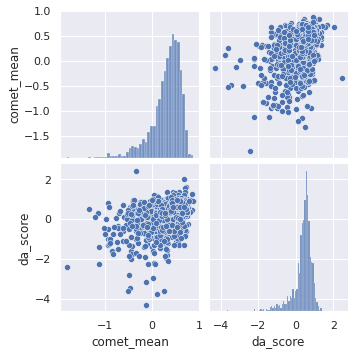

In [26]:
g = sns.pairplot(tmp_df[['comet_mean', 'da_score']])

In [27]:
tmp_df['comet_mean'].mean() 

0.3041091460753029

In [28]:
tmp_df['da_score'].mean()

0.3465381976497918

In [29]:
tmp_df['comet_mean'].min()

-1.8134834617376328

In [30]:
tmp_df['comet_mean'].max()

0.8724681809544563

In [31]:
tmp_df['da_score'].min()

-4.30188188115954

In [32]:
tmp_df['da_score'].max()

2.43796983116887

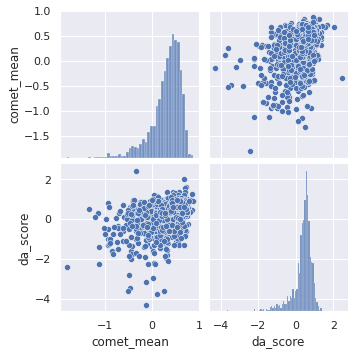

In [33]:
sns.pairplot(tmp_df[['comet_mean', 'da_score']])

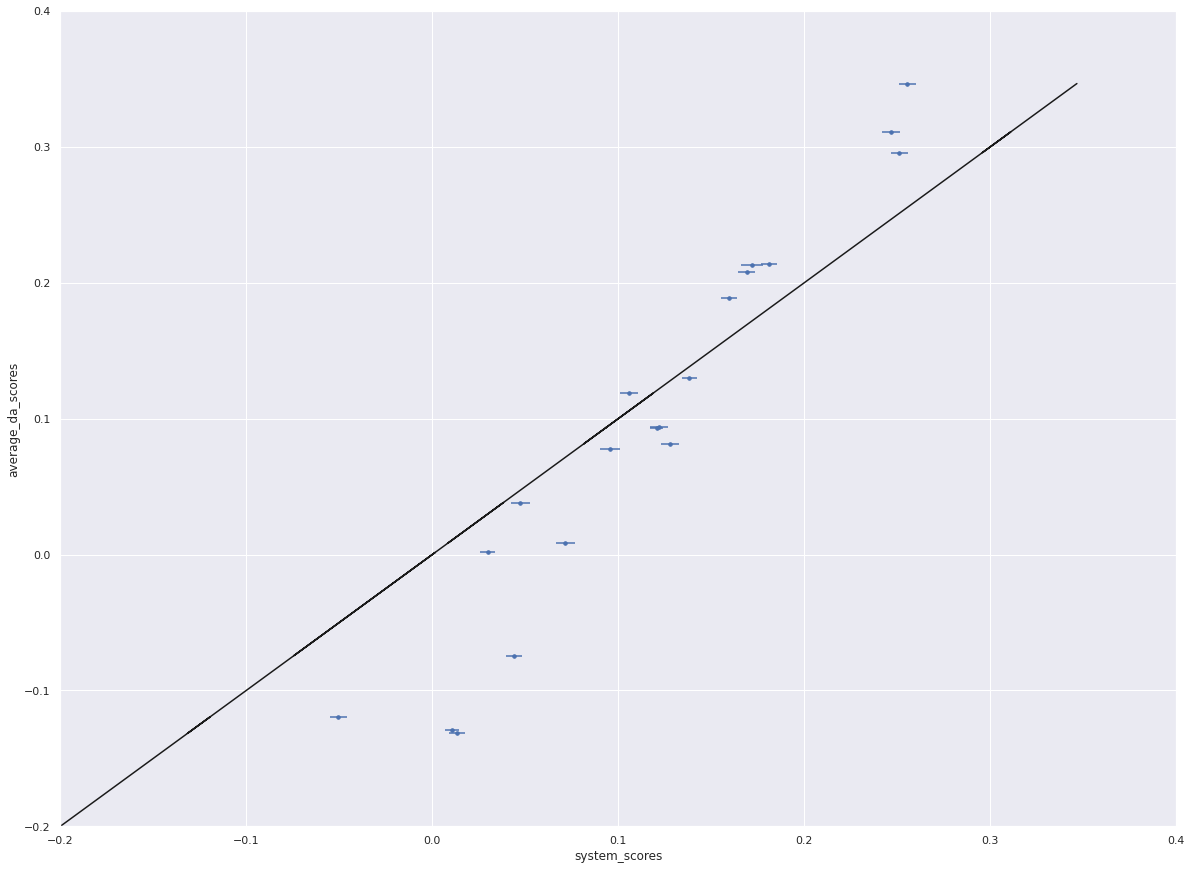

In [22]:
plt.figure(figsize=(20,15))

x = np.array(system_scores)
y = np.array(avg_das)
xerr = 2*np.array(system_stds)
x, y = zip(*sorted(zip(x, y)))

plt.plot(x,y,'b.', markersize=7) # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
plt.errorbar(x, y, xerr=xerr, fmt='none')


plt.xlim(-0.2,0.4)
plt.ylim(-0.2,0.4)

plt.xlabel('system_scores')
plt.ylabel('average_da_scores')
plt.show()

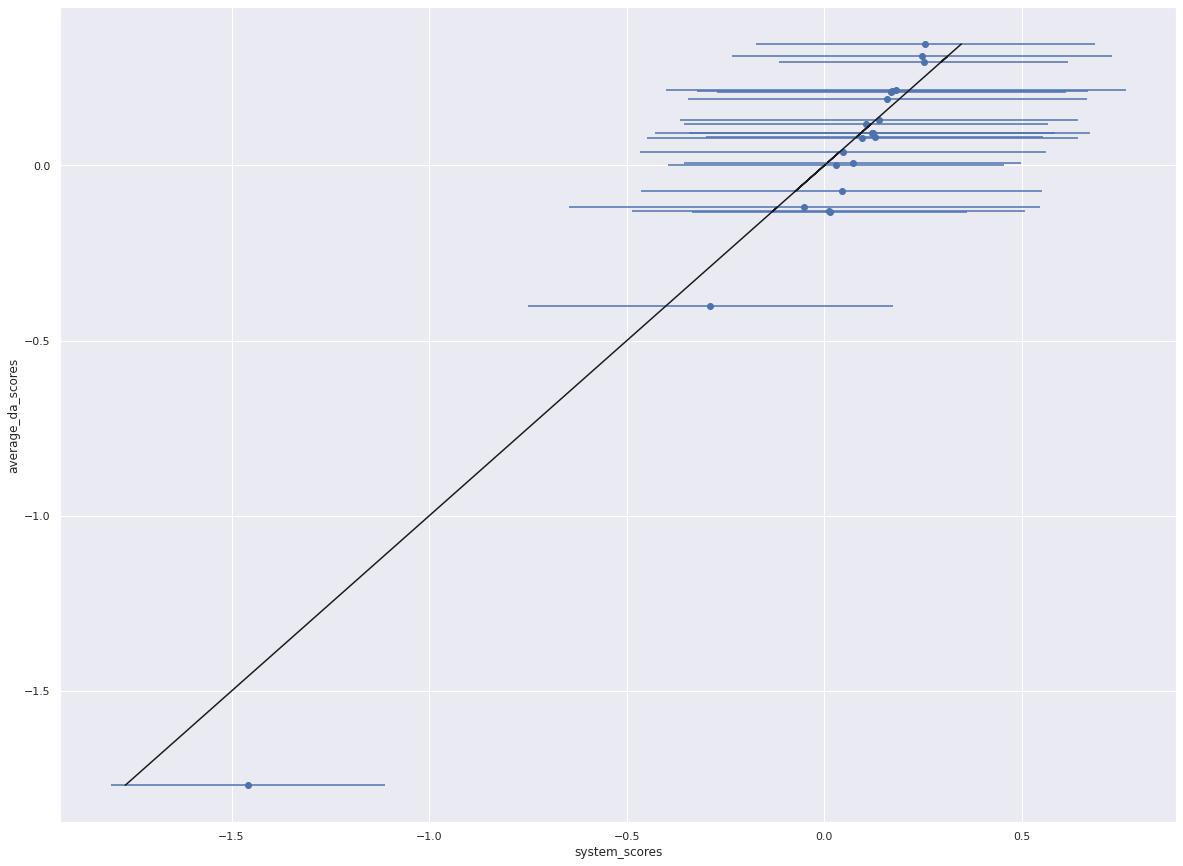

In [39]:
plt.figure(figsize=(20,15))

x = np.array(system_scores)
y = np.array(avg_das)
xerr = np.array(system_stds_)
x, y = zip(*sorted(zip(x, y)))

plt.plot(x,y,'b.', markersize=12) # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('system_scores')
plt.ylabel('average_da_scores')
plt.show()

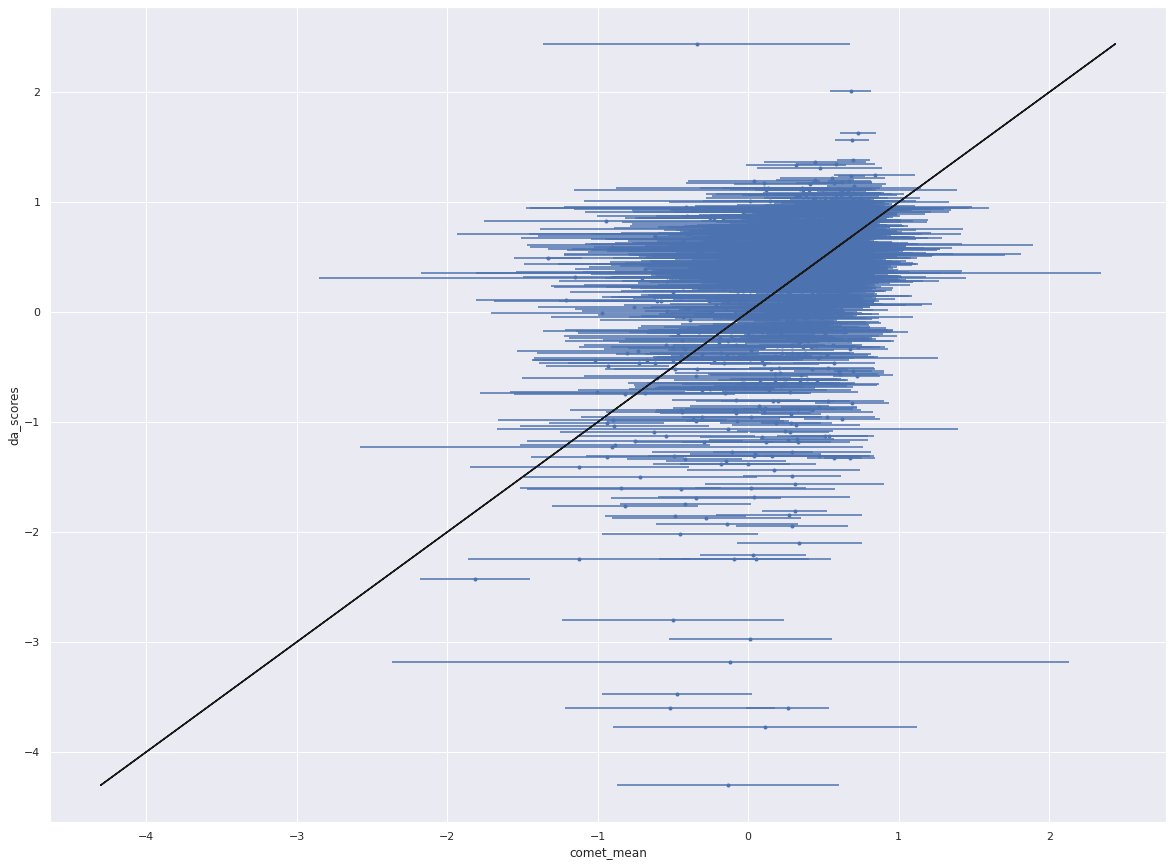

In [402]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_mean'].tolist())
y = np.array(tmp_df['da_score'].tolist())
xerr = 2*np.array(tmp_df['comet_std'].tolist())
x, y = zip(*sorted(zip(x, y)))

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_mean')
plt.ylabel('da_scores')
plt.show()

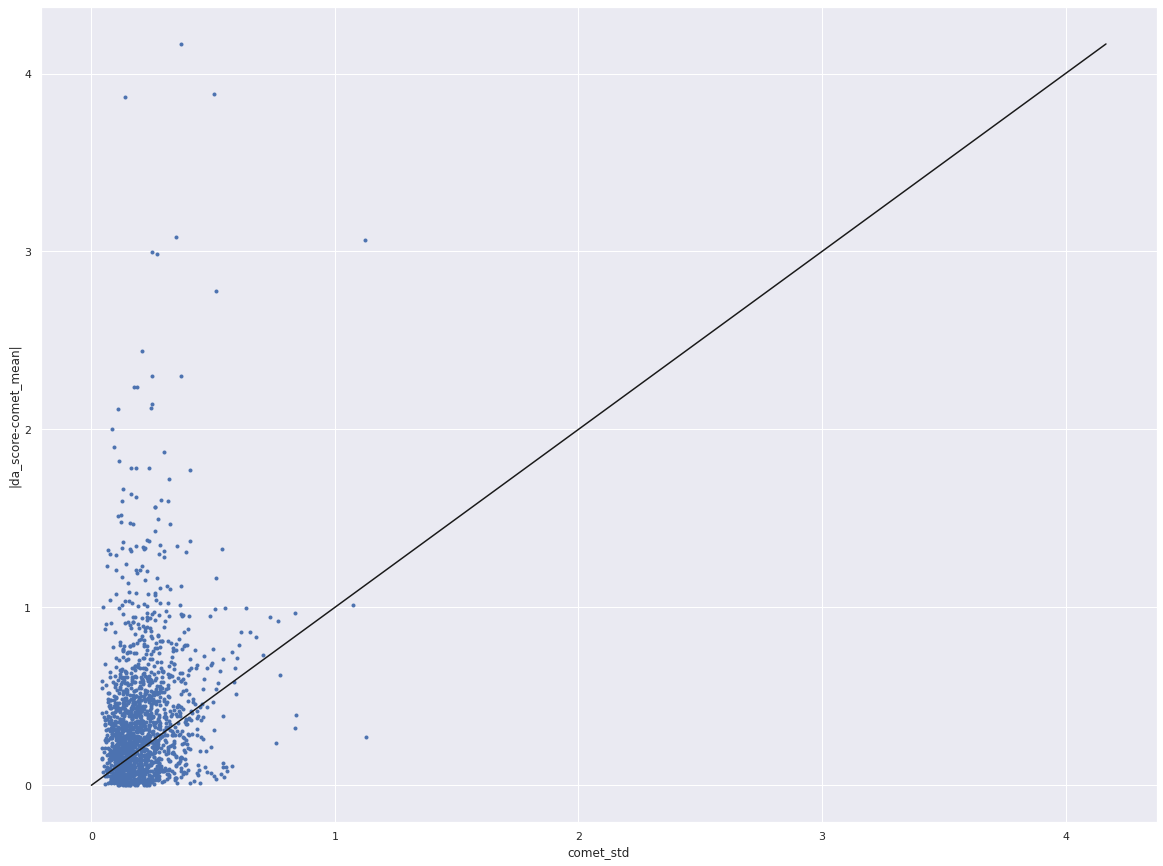

In [37]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_std'].tolist())
y = np.array(tmp_df['|da_score-comet_mean|'].tolist())
# xerr = 2*np.array(tmp_df['comet_std'].tolist())

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
# plt.errorbar(x, y, xerr=xerr, fmt='none')



# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_std')
plt.ylabel('|da_score-comet_mean|')
plt.show()

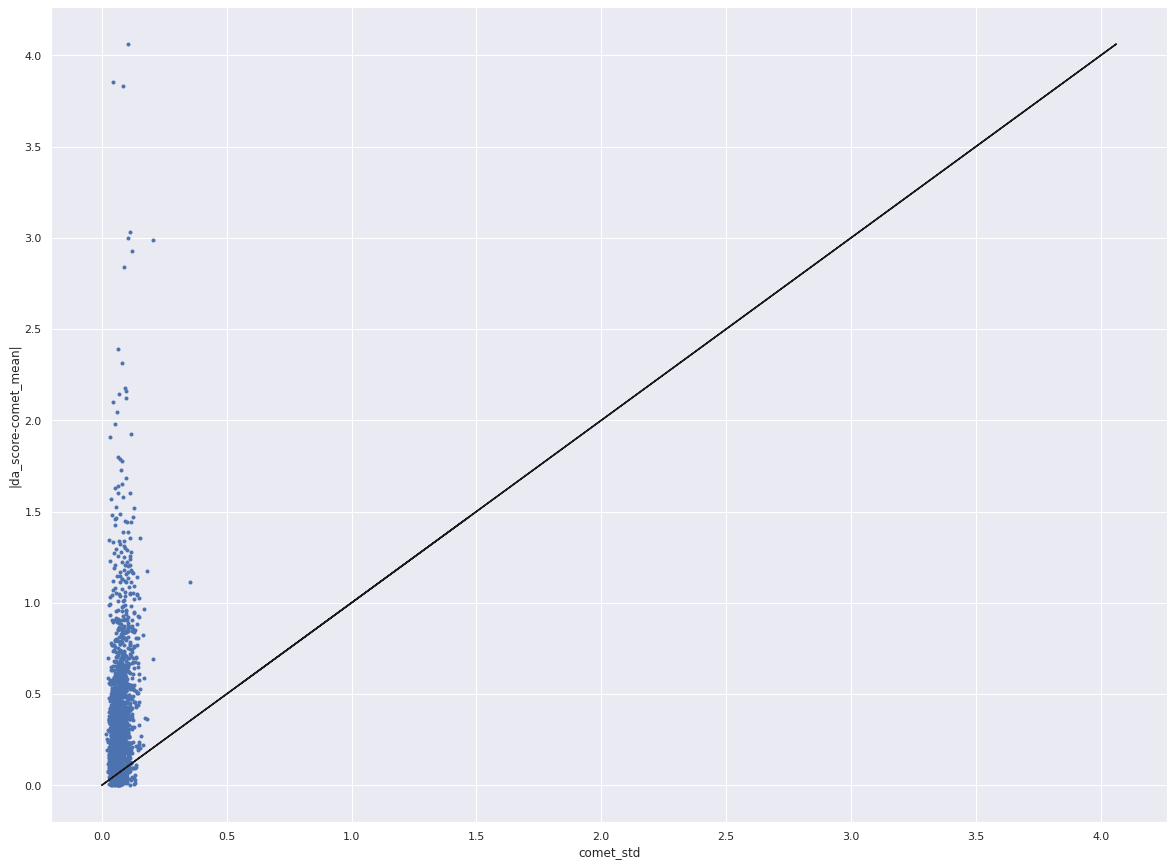

In [248]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_std'].tolist())
y = np.array(tmp_df['|da_score-comet_mean|'].tolist())
# xerr = 2*np.array(tmp_df['comet_std'].tolist())

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
# plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_std')
plt.ylabel('|da_score-comet_mean|')
plt.show()

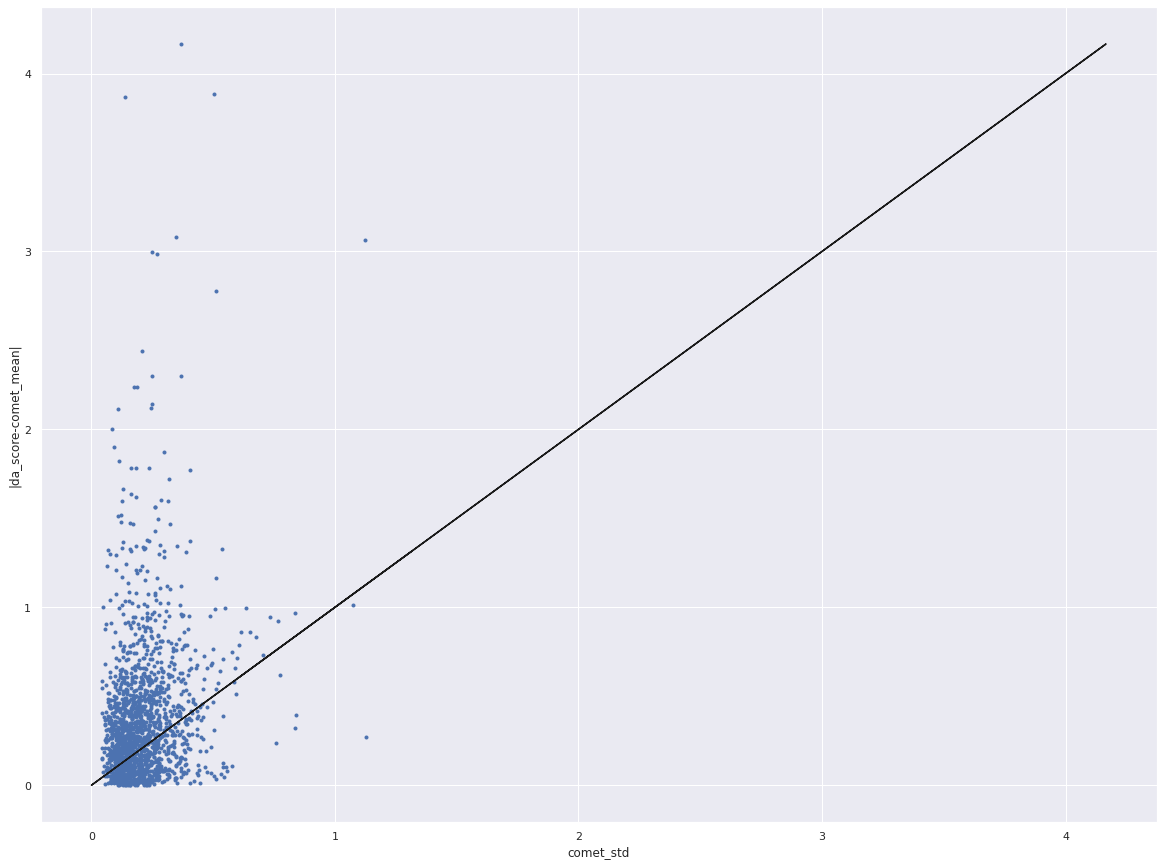

In [294]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_std'].tolist())
y = np.array(tmp_df['|da_score-comet_mean|'].tolist())
# xerr = 2*np.array(tmp_df['comet_std'].tolist())

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
# plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_std')
plt.ylabel('|da_score-comet_mean|')
plt.show()

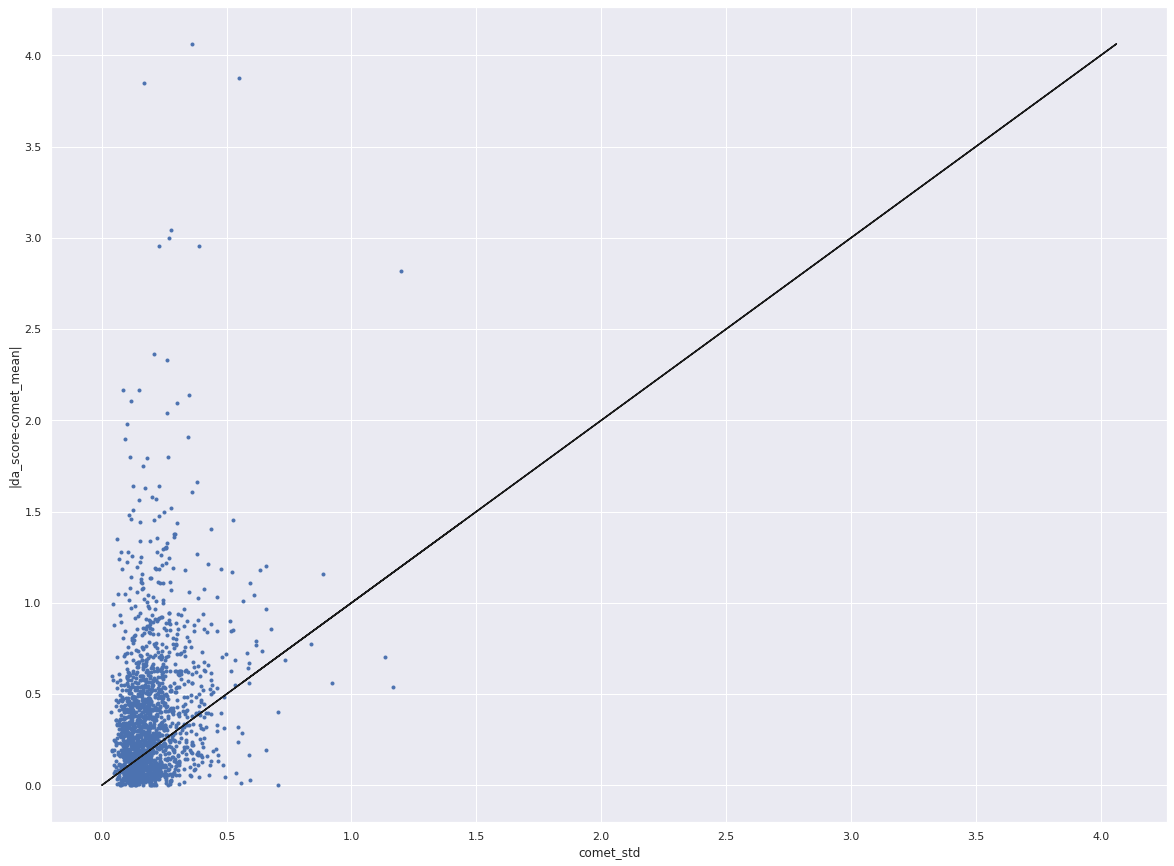

In [215]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_std'].tolist())
y = np.array(tmp_df['|da_score-comet_mean|'].tolist())
# xerr = 2*np.array(tmp_df['comet_std'].tolist())

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
# plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_std')
plt.ylabel('|da_score-comet_mean|')
plt.show()

In [93]:
xerr.min()

0.0371422003954584

In [94]:
xerr.max()

0.7089760817897498

In [111]:
# comet_mean
min_thres = 0
max_thres = 0.7

# da_score
min_thres_da = 0
max_thres_da = 1

In [ ]:
# comet_mean
min_thres = 0
max_thres = 0.7

# da_score
min_thres_da = 0
max_thres_da = 1

In [112]:
# tmp_df[tmp_df.comet_mean <= 0].shape
print('negative')
negative_std = tmp_df[tmp_df.comet_mean <= min_thres].comet_std
print('min: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.min())
print('max: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.max())
print('avg: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.mean())
print()

# tmp_df[tmp_df.comet_mean >= 1].shape
print('positive')
positive_std = tmp_df[tmp_df.comet_mean >= max_thres].comet_std
print('min: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.min())
print('max: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.max())
print('avg: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.mean())
print()

a = tmp_df[tmp_df.comet_mean > min_thres]
a[a.comet_mean < 1].shape
# tmp_df[[tmp_df.comet_mean > 0 and tmp_df.comet_mean < 1]].shape

print('neutral')
neutral_std = a[a.comet_mean < max_thres].comet_std
print('min: ', a[a.comet_mean < max_thres].comet_std.min())
print('max: ', a[a.comet_mean < max_thres].comet_std.max())
print('avg: ', a[a.comet_mean < max_thres].comet_std.mean())
print()

negative
min:  0.0573926418674381
max:  0.3544880408948749
avg:  0.10403730151084997

positive
min:  0.0185711001977292
max:  0.0761347780327174
avg:  0.034773373600824616

neutral
min:  0.0208923867171933
max:  0.2064418663633574
avg:  0.0660813844965845



[Text(0.5, 0, 'std value')]

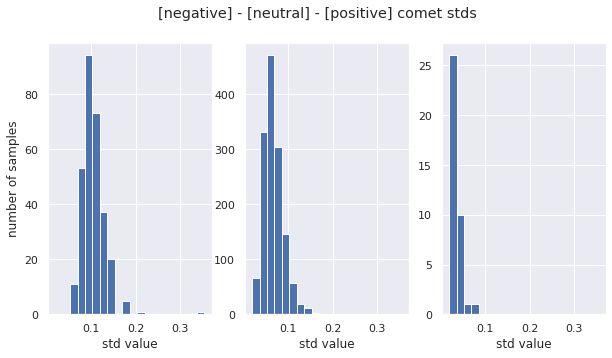

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('[negative] - [neutral] - [positive] comet stds')
ax1.hist(negative_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax2.hist(neutral_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax3.hist(positive_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)

ax1.set(xlabel='std value', ylabel='number of samples')
ax2.set(xlabel='std value')
ax3.set(xlabel='std value')

In [114]:
print('negative')
# tmp_df[tmp_df.comet_mean <= 0.3].shape
negative_std_da = tmp_df[tmp_df.da_score <= min_thres_da].comet_std
print('min: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.min())
print('max: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.max())
print('avg: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.mean())
print()

print('positive')
# tmp_df[tmp_df.comet_mean >= 1].shape
positive_std_da = tmp_df[tmp_df.da_score >= max_thres_da].comet_std
print('min: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.min())
print('max: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.max())
print('avg: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.mean())
print()

a = tmp_df[tmp_df.da_score > min_thres_da]
a[a.da_score < 1].shape
# tmp_df[[tmp_df.comet_mean > 0 and tmp_df.comet_mean < 1]].shape
print('neutral')
neutral_std_da = a[a.da_score < max_thres_da].comet_std
print('min: ', a[a.da_score < max_thres_da].comet_std.min())
print('max: ', a[a.da_score < max_thres_da].comet_std.max())
print('mean: ', a[a.da_score < max_thres_da].comet_std.mean())
print()

negative
min:  0.0268372451026809
max:  0.2071772001538955
avg:  0.07207150667604072

positive
min:  0.0253347349697069
max:  0.1214190658159835
avg:  0.06478416737772179

neutral
min:  0.0185711001977292
max:  0.3544880408948749
mean:  0.07207510305622264



[Text(0.5, 0, 'std value')]

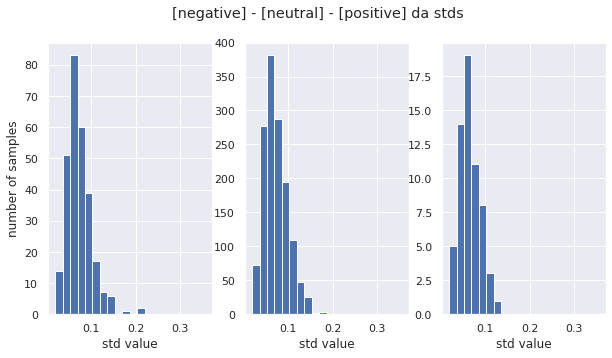

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('[negative] - [neutral] - [positive] da stds')
ax1.hist(negative_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax2.hist(neutral_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax3.hist(positive_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)

ax1.set(xlabel='std value', ylabel='number of samples')
ax2.set(xlabel='std value')
ax3.set(xlabel='std value')


In [119]:
comet_splits = [negative_std, neutral_std, positive_std]
da_splits = [negative_std_da, neutral_std_da, positive_std_da]

comet_splits_names = ['negative_std_comet', 'neutral_std_comet', 'positive_std_comet']
da_splits_names = ['negative_std_da', 'neutral_std_da', 'positive_std_da']

In [120]:
pairs = [(c, da) for c in comet_splits for da in da_splits]
pairs_names = [(c, da) for c in comet_splits_names for da in da_splits_names]

intersecs = []

for pair, name in zip(pairs, pairs_names):
    print(name)
    common_idx = pair[0].index.intersection(pair[1].index)
    common = pair[0].loc[common_idx]
    print('min: ', common.min())
    print('max: ', common.max())
    print('mean: ', common.mean())
    print('# samples: ', len(common))
    intersecs.append(common)
#     plt.hist(common, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
#     plt.show()
    print()

# zip(pairs, pairs_names)

('negative_std_comet', 'negative_std_da')
min:  0.0579687067508886
max:  0.2071772001538955
mean:  0.10082157045943184
# samples:  67

('negative_std_comet', 'neutral_std_da')
min:  0.0573926418674381
max:  0.3544880408948749
mean:  0.10535450775668247
# samples:  217

('negative_std_comet', 'positive_std_da')
min:  0.0701997494651631
max:  0.1214190658159835
mean:  0.0976391401562468
# samples:  11

('neutral_std_comet', 'negative_std_da')
min:  0.0268372451026809
max:  0.2064418663633574
mean:  0.06383591990033705
# samples:  207

('neutral_std_comet', 'neutral_std_da')
min:  0.0208923867171933
max:  0.166195460320451
mean:  0.06681829600592791
# samples:  1155

('neutral_std_comet', 'positive_std_da')
min:  0.0253347349697069
max:  0.100246453281632
mean:  0.05819726976457589
# samples:  49

('positive_std_comet', 'negative_std_da')
min:  0.0321078887000248
max:  0.0406145860921066
mean:  0.0351568715232837
# samples:  6

('positive_std_comet', 'neutral_std_da')
min:  0.018571100197

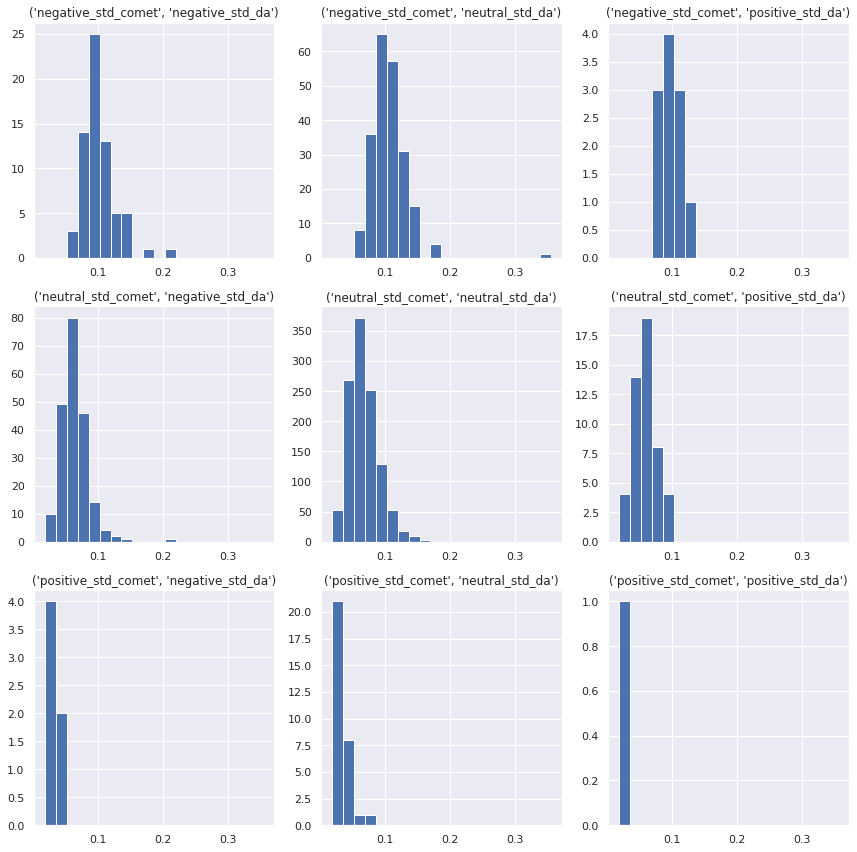

In [121]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
# fig.suptitle('[negative] - [neutral] - [positive] intersections')

axs[0,0].hist(intersecs[0], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,0].set_title(pairs_names[0])
axs[0,1].hist(intersecs[1], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,1].set_title(pairs_names[1])
axs[0,2].hist(intersecs[2], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,2].set_title(pairs_names[2])

axs[1,0].hist(intersecs[3], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,0].set_title(pairs_names[3])
axs[1,1].hist(intersecs[4], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,1].set_title(pairs_names[4])
axs[1,2].hist(intersecs[5], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,2].set_title(pairs_names[5])

axs[2,0].hist(intersecs[6], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,0].set_title(pairs_names[6])
axs[2,1].hist(intersecs[7], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,1].set_title(pairs_names[7])
axs[2,2].hist(intersecs[8], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,2].set_title(pairs_names[8])

fig.tight_layout()
# ax1.set(xlabel='std value', ylabel='number of samples')
# ax2.set(xlabel='std value')
# ax3.set(xlabel='std value')



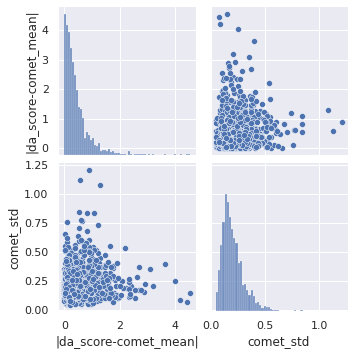

In [146]:
sns.pairplot(tmp_df[['|da_score-comet_mean|', 'comet_std']])


Text(0, 0.5, 'values')

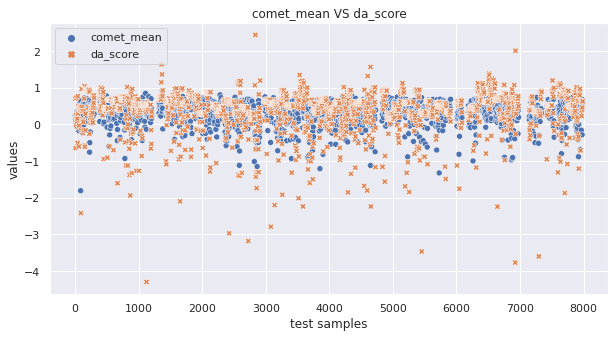

In [147]:
sns.scatterplot(data=tmp_df[['comet_mean', 'da_score']])
plt.title('comet_mean VS da_score')
plt.xlabel('test samples')
plt.ylabel('values')

Text(0, 0.5, 'values')

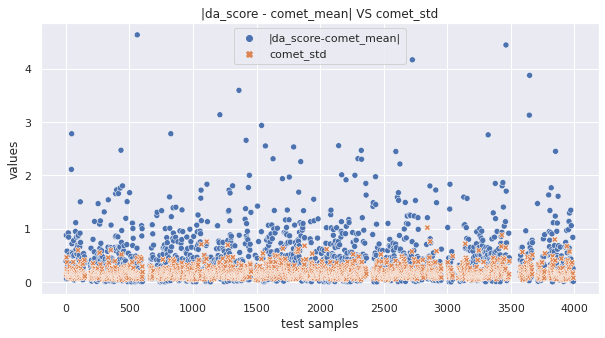

In [49]:
sns.scatterplot(data=tmp_df[['|da_score-comet_mean|', 'comet_std']])
plt.title('|da_score - comet_mean| VS comet_std')
plt.xlabel('test samples')
plt.ylabel('values')

## evaluation based on the log-likelihood metric  
log p(q | mu, sigma_sq) 


In [105]:
from scipy.stats import norm

In [106]:
eps = np.finfo(float).eps # to avoid -inf when computing np.log(0)
eps

2.220446049250313e-16

In [107]:
tmp = []
probs = []
for i, q in enumerate(z_scores):
    prob = norm.pdf(q, mean_vals[i], std_vals[i])
    probs.append(prob)
    tmp.append(np.log(prob+eps))

In [108]:
np.sum(np.log(probs+eps))

-26076.26284792655

In [109]:
round(np.sum(np.log(probs+eps))/len(probs), 6) #! the value we want to compare (want: as big as possible) 
# z_scores and not norm comet

-14.951986

In [99]:
# or as small as possible
np.abs(np.sum(np.log(probs+eps))/len(probs)) #! the value we want to compare 

4.632666848551917

In [110]:
from scipy.stats import norm
from scipy.stats import pearsonr

score_diff=[]
for zs, cs in zip(z_scores, mean_vals):
    score_diff.append(abs(zs - cs))
    
pearson_corr = pearsonr(score_diff, std_vals)
print(round(pearson_corr[0], 6))
pearson_corr

0.214448


(0.21444798879996835, 1.3690747650339207e-19)

In [ ]:
# try norm.logpdf

In [147]:
norm.var(mean_vals[0],0.01)

0.0001

In [142]:
# var starting from 0.001 to 0.5, step 0.001
# find optomal std for a baseline

vals = []
for j in tqdm(np.arange(0.5, 0.8, 0.001)): 
    probs = []
    for i, q in enumerate(z_scores):
        prob = norm.pdf(q, mean_vals[i], j)
        probs.append(prob)
    vals.append(np.sum(np.log(probs+eps))/len(probs))

100%|██████████| 301/301 [00:53<00:00,  5.61it/s]


In [143]:
np.argmax(vals)

300

In [144]:
vals[np.argmax(vals)]

-1.6878358116439027

In [137]:
np.arange(0.001, 0.5, 0.001)[498]

0.499

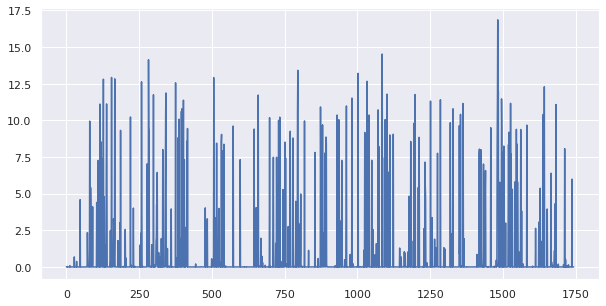

In [69]:
plt.plot(probs, color='b')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


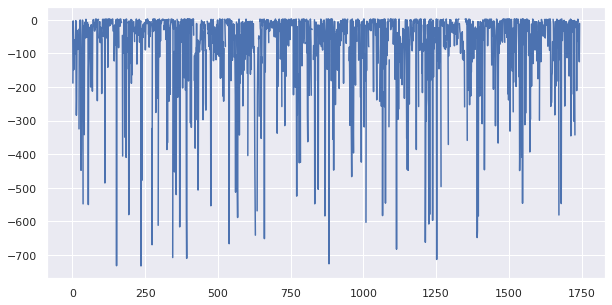

In [88]:
plt.plot(np.log(probs), color='b')

In [35]:
np.sum(tmp)

-37572.37062613824

In [74]:
np.log(norm.pdf(z_scores, mean, std))

array([  0.35527887, -10.78837592,  -2.41678263, ...,   0.38723281,
         0.18440155,   0.38723281])

In [72]:
np.log(norm.pdf(z_scores, mean, std)).sum()

-4415.865239777251

In [73]:
# np.log(norm.pdf(z_scores_norm, mean, std)).sum()

In [28]:
probs = norm.pdf(z_scores, mean, std)
probs

array([1.42657842e+00, 2.06380123e-05, 8.92081720e-02, ...,
       1.47289936e+00, 1.20249859e+00, 1.47289936e+00])

In [29]:
np.array(probs).any() >= 1

True

In [ ]:
probs

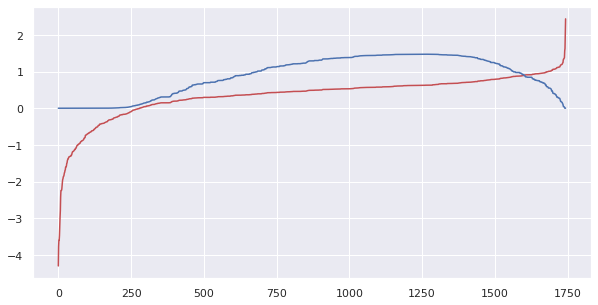

In [28]:
z_scores, probs = zip(*sorted(zip(z_scores, probs)))

plt.plot(z_scores, color='r')
plt.plot(probs, color='b')
# plt.plot(np.log(probs), color='g')
plt.show()

# positive-neutral-negative

		
DAs\comet	positive   neutral	negative       
positive	  <<	      >>	   >>      
neutral	      >>	      <<	   >>       
negative	  >>	      >>	   >>      



In [106]:
# comet_mean
# negative <= -1.5
# neutral >-1.5 and <1.5
# positive >=1.5

# da_score
# negative <= -1.5
# neutral >-1.5 and <1.5
# positive >=1.5

Freedman–Diaconis number of bins: 32


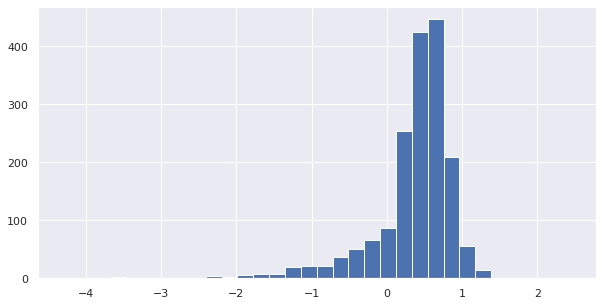

In [93]:
x = np.array(z_scores)
q25, q75 = np.percentile(x,[.25,.75])
bin_width = 2*(q75 - q25)*len(x)**(-1/3)
bins = round((x.max() - x.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins = bins);

# plt.hist(z_scores)

In [104]:
len(x)

1744

In [101]:
((x<0)*1).sum()

280

In [105]:
((x>=0)*1).sum()

1464

Freedman–Diaconis number of bins: 61


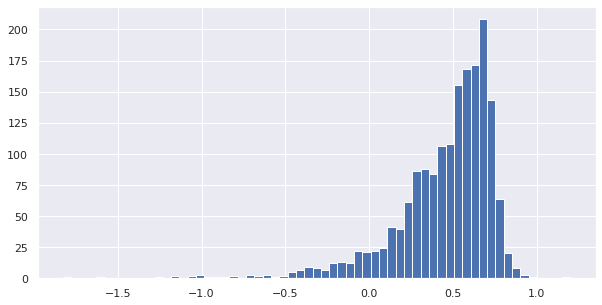

In [92]:
x = np.array(mean_vals)
q25, q75 = np.percentile(x,[.25,.75])
bin_width = 2*(q75 - q25)*len(x)**(-1/3)
bins = round((x.max() - x.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins = bins);

# plt.hist(z_scores)

## t-test

7 and 9       
segments-lw-dropout-01.json     
segments-fulltrain-dropout-01.json     

11 and 16     
segments-fulltrain-90dpruns.json      
segments-ar-arp-wmtp-fulltrain.json

In [3]:
## Import the packages
import numpy as np
from scipy import stats
import json

In [73]:
# 7 and 9       
# segments-lw-dropout-01.json     
# segments-fulltrain-dropout-01.json    

f1 = open('/media/hdd1/glushkovato/comet/segments-lw-dropout-01.json', 'r')
f2 = open ('/media/hdd1/glushkovato/comet/segments-fulltrain-dropout-01.json', "r") 


data1 = json.loads(f1.read()) 
f1.close() 

data2 = json.loads(f2.read()) 
f2.close() 

In [74]:
lines = []
for i in data1:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df1 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df = df.iloc[::1, :]
# df1.iloc[:3]

In [75]:
lines = []
for i in data2:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df2 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df = df.iloc[::1, :]
# df2.iloc[:3]

In [76]:
a = np.array(df1.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())
b = np.array(df2.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. 

If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [77]:
## Cross Checking with the internal scipy function
t, p = stats.ttest_ind(a, b)
print("t = " + str(t))
print("p = " + str(p))

t = -6.216871760108584
p = 5.592234482107767e-10


In [78]:
p < 0.1

True

In [59]:
a.var()

0.002598976945724452

In [60]:
b.var()

0.002190845287664956

In [62]:
# 11 and 16     
# segments-fulltrain-90dpruns.json      
# segments-ar-arp-wmtp-fulltrain.json

f1 = open('/media/hdd1/glushkovato/comet/segments-fulltrain-90dpruns.json', 'r')
f2 = open('/media/hdd1/glushkovato/comet/segments-ar-arp-wmtp-fulltrain.json', 'r')

data1 = json.loads(f1.read()) 
f1.close() 

data2 = json.loads(f2.read()) 
f2.close() 

In [63]:
lines = []
for i in data1:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df1 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])


lines = []
for i in data2:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df2 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

In [64]:
a = np.array(df1.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())
b = np.array(df2.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())

In [65]:
## Cross Checking with the internal scipy function
t, p = stats.ttest_ind(a, b, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = -59.86919612471615
p = 0.0


In [66]:
a.var()

0.0020971998514667176

In [67]:
b.var()

0.013622735865360409

1.0170239441069984
t = 2.801981914210512
p = 0.011786556548031069
t = 2.8019819142105113
p = 0.011786556548031204


In [37]:
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
b = np.random.randn(N)

In [38]:
a.mean()

1.6802589204639933

In [39]:
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)
b.mean()

0.4058420751884923

In [ ]:
## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))